In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://raw.githubusercontent.com/martinwg/ISA630/refs/heads/master/data/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [2]:
## Goal: Customer Segmentation,
#### Build a cluster analysis model to segment the mall customers

In [5]:
## drop CustomerID
df.drop('CustomerID', axis=1, inplace=True)

## encode Gender
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,19,15,39,True
1,21,15,81,True
2,20,16,6,False
3,23,16,77,False
4,31,17,40,False


In [8]:
df.tail()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
195,35,120,79,False
196,45,126,28,False
197,32,126,74,True
198,32,137,18,True
199,30,137,83,True


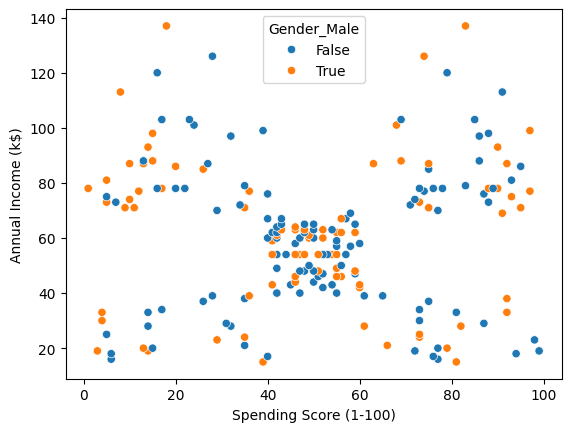

In [6]:
## plot Spending Score vs Annual Code (Color Coder Gender)

sns.scatterplot(data=df, x='Spending Score (1-100)', y='Annual Income (k$)', hue='Gender_Male');

In [7]:
## What if we have many variables?
## Use PCA (Principal component analysis) - combine the information of ALL VARIABLES
## Only obtain PC1 and PC2
## plot those and decide the segments (if visible)

In [12]:
## Measures of Distance
## L2 Norm (Euclidian Norm)

## vectorize obs 1 (index 0)
cust0 = df.iloc[0, :].values.astype('int')
## vectorize obs 2 (index 1)
cust1 = df.iloc[1, :].values.astype('int')
## vectorize obs 200 (index 199)
cust199 = df.iloc[199, :].values.astype('int')

In [15]:
## distance (customer 0 and customer 1)
## euclidean distance between the two customers
np.linalg.norm(cust0 - cust1)

42.04759208325728

In [16]:
## distance (customer 0 and customer 199)
## euclidean distance between the two customers
np.linalg.norm(cust0 - cust199)

130.15759678174763

In [17]:
## The algorithm is going to measure distances between obs
## and then group them

In [18]:
## Cluster Analysis

## Step 1) Standardize to same units
from sklearn.preprocessing import StandardScaler

## instance
scaler = StandardScaler()

## standardized data using .fit_transform
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,1.128152
1,-1.281035,-1.738999,1.195704,1.128152
2,-1.352802,-1.700830,-1.715913,-0.886405
3,-1.137502,-1.700830,1.040418,-0.886405
4,-0.563369,-1.662660,-0.395980,-0.886405


In [20]:
## Step 2) Clustering Algorithm (Agglomerative Method)
#### starts with every obs as a cluster
#### combines those with the closest distances
from sklearn.cluster import AgglomerativeClustering

## instance
#### you need to specify how many clusters to make (intuition, PC1 vs PC2 )
cluster_model = AgglomerativeClustering(n_clusters=5, metric = "euclidean", linkage = "ward")

## fit the model and predict on SCALED data
cluster_assignment = cluster_model.fit_predict(df_scaled)

In [22]:
df_scaled['cluster'] = cluster_assignment
df_scaled.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,cluster
0,-1.424569,-1.738999,-0.434801,1.128152,0
1,-1.281035,-1.738999,1.195704,1.128152,0
2,-1.352802,-1.700830,-1.715913,-0.886405,3
3,-1.137502,-1.700830,1.040418,-0.886405,0
4,-0.563369,-1.662660,-0.395980,-0.886405,3


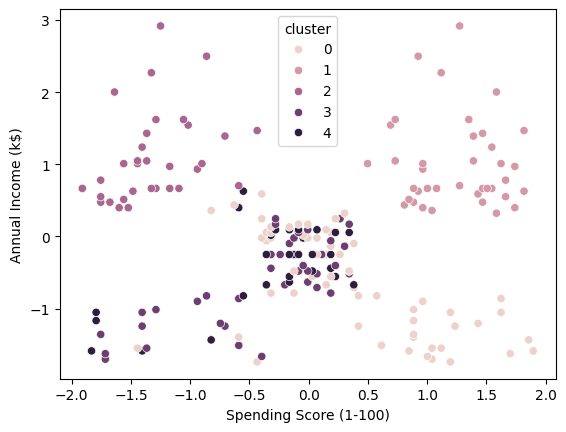

In [23]:
## plot Spending Score vs Annual Code (Color Coder Cluster)

sns.scatterplot(data=df_scaled, x='Spending Score (1-100)', y='Annual Income (k$)', hue='cluster');

In [24]:
## How many clusters?
## Plot PC1 vs PC2 (blob of data)

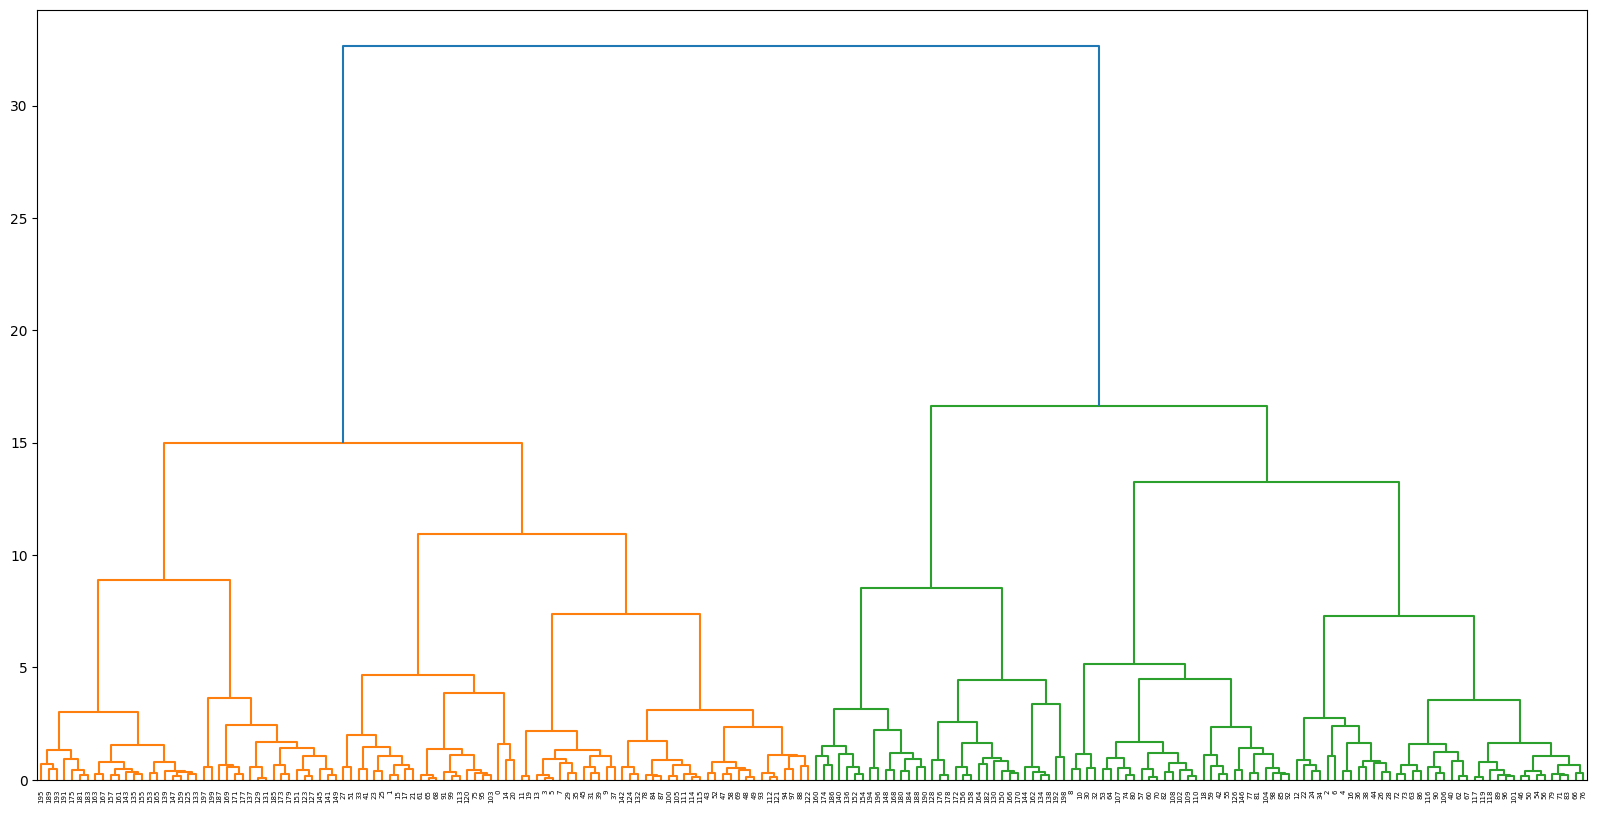

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize = (20,10))
linkage_data = linkage(df_scaled, method = "ward", metric = "euclidean")
dendrogram(linkage_data)
plt.show()

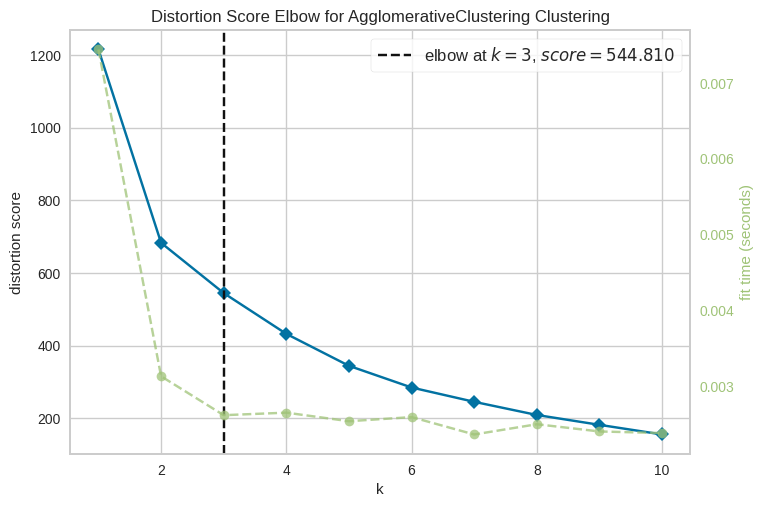

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
## for LARGER data sets, dendogram is NOT efficient
## Elbow algorithm measures the variances of the distances
## finds the number of clusters optimal to decrease variances
#### ISSUE: Might not converge
from yellowbrick.cluster import KElbowVisualizer

model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(df_scaled)
visualizer.show()

In [30]:
## Statistical Distances Include the VARIANCE-COVARIANCE information
## It takes into account CORRELATION
## The covariance matrix is A SQUARE matrix (# cols = # rows)
## It is symmetric C' = C (row 1 =  col 1, row 2 = col 2)
## diagonal values are the variances (variables)
## the off-diagonals are the covariance (correlations)
np.round(np.cov(df.values.astype('int').T))

array([[ 195.,   -5., -118.,    0.],
       [  -5.,  690.,    7.,    1.],
       [-118.,    7.,  667.,   -1.],
       [   0.,    1.,   -1.,    0.]])

In [31]:
## variance of Age
np.var(df['Age'])

194.1575000000001

In [32]:
## the correlation (kind of) between Age and Income (how they vary together)
## -5. (negative correlation)

In [33]:
## Distances can be calculated using STATISTICAL (MAHALANOBIS)
## cust0 and cust1
(cust0 - cust1).T.dot(np.linalg.inv(np.cov(df.values.astype('int').T))).dot(cust0 - cust1)

3.1602348969137606